/var/folders/tz/tw3ctq595r744r_sx025n5hc0000gn/T/ipykernel_5406/1402750231.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2020-01-01', end='2025-01-01')['Close']
[*********************100%***********************]  1 of 1 completed

Descargando datos de CEMEXCPO.MX...

--- RESUMEN DEL MODELO GARCH ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                  CEMEXCPO.MX   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2904.12
Distribution:      Standardized Student's t   AIC:                           5818.25
Method:                  Maximum Likelihood   BIC:                           5843.93
                                              No. Observations:                 1258
Date:                      Sat, Jan 10 2026   Df Residuals:                     1257
Time:                              19:32:22   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
-------------------

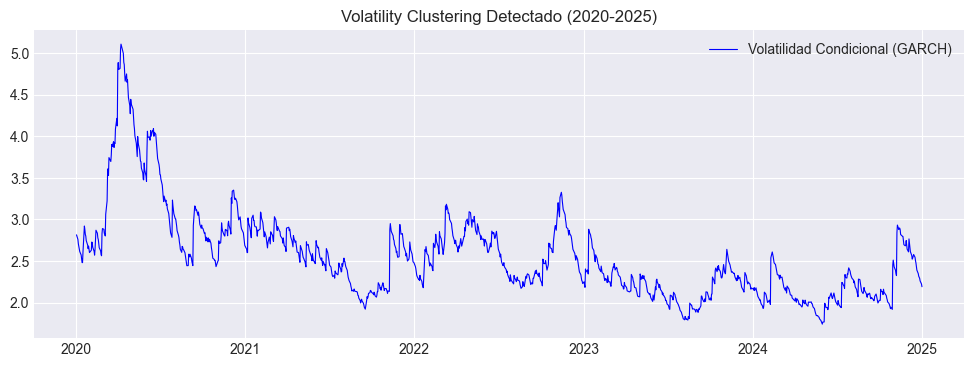

In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model # La librería pro para GARCH

# --- 1. DATOS REALES (El mercado mexicano) ---
ticker = 'CEMEXCPO.MX' # Cemex es volátil, perfecto para esto
print(f"Descargando datos de {ticker}...")
data = yf.download(ticker, start='2020-01-01', end='2025-01-01')['Close']

# Retornos logarítmicos (multiplicados por 100 para estabilidad numérica en GARCH)
returns = 100 * data.pct_change().dropna()

# --- 2. EL CEREBRO: AJUSTE DEL MODELO GARCH(1,1) ---
# Basado en SFM Cap. 12 (Time Series) y Cap. 14
# Asumimos una media constante y volatilidad GARCH
model = arch_model(returns, vol='Garch', p=1, q=1, dist='t') # dist='t' para Colas Pesadas (Student's t)
res = model.fit(disp='off')

print("\n--- RESUMEN DEL MODELO GARCH ---")
print(res.summary())

# --- 3. FILTERED HISTORICAL SIMULATION (FHS) ---
# Paso A: Obtener los residuos estandarizados (Z)
# Quitamos la volatilidad histórica para dejar solo el "ruido" puro
volatilidad_historica = res.conditional_volatility
std_resid = res.resid / volatilidad_historica

# Paso B: Predecir la volatilidad para MAÑANA
forecasts = res.forecast(horizon=1)
vol_mañana = np.sqrt(forecasts.variance.values[-1, :])[0]

# Paso C: Bootstrap (Simulación)
# Tomamos los residuos pasados al azar y les inyectamos la volatilidad de mañana
n_simulaciones = 10000
simulated_resid = np.random.choice(std_resid, n_simulaciones, replace=True)
simulated_returns = simulated_resid * vol_mañana # Retorno simulado = Ruido Histórico * Volatilidad Actual

# --- 4. CÁLCULO DE VaR y ES (Expected Shortfall) ---
conf_level = 0.95
VaR_95 = np.percentile(simulated_returns, (1-conf_level)*100)
ES_95 = simulated_returns[simulated_returns <= VaR_95].mean() # Promedio de pérdidas en el peor 5%

# Convertir a dinero (Ejemplo: Portafolio de $1,000,000)
capital = 1000000
VaR_cash = (VaR_95 / 100) * capital
ES_cash = (ES_95 / 100) * capital

print(f"\n--- RIESGO ESTIMADO PARA MAÑANA ({ticker}) ---")
print(f"Volatilidad Proyectada: {vol_mañana:.2f}% diaria")
print(f"VaR (95%) con GARCH-FHS: ${abs(VaR_cash):,.2f}")
print(f"Expected Shortfall (CVaR): ${abs(ES_cash):,.2f} <--- La métrica que ven los reguladores")

# --- 5. VISUALIZACIÓN 'TEXTBOOK STYLE' ---
plt.figure(figsize=(12, 6), dpi = 1500)
plt.style.use('seaborn-v0_8-darkgrid')

# Histograma de retornos simulados
sns.histplot(simulated_returns, bins=100, kde=True, color='#2c3e50', stat='density', alpha=0.6, label='Escenarios Simulados (FHS)')

# Líneas de Riesgo
plt.axvline(VaR_95, color='#e74c3c', linestyle='--', linewidth=2, label=f'VaR 95%: {VaR_95:.2f}%')
plt.axvline(ES_95, color='#f1c40f', linestyle='-', linewidth=2, label=f'Expected Shortfall: {ES_95:.2f}%')

plt.title(f'Pronóstico de Riesgo Dinámico (GARCH-FHS) para {ticker}', fontsize=14)
plt.xlabel('Retorno Diario Simulado (%)')
plt.ylabel('Densidad')
plt.legend()
plt.show()

# Gráfico Extra: Volatilidad en el tiempo (Para mostrar que detectas clusters)
plt.figure(figsize=(12, 4))
plt.plot(volatilidad_historica, color='blue', linewidth=0.8, label='Volatilidad Condicional (GARCH)')
plt.title('Volatility Clustering Detectado (2020-2025)', fontsize=12)
plt.legend()
plt.show()